In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%reload_ext snakeviz
%reload_ext line_profiler

# Purpose

Ripple decoding takes ~1 hr for all the ripples. I added code to parallelize this operation, but it was failing on the cluster or not speeding up the operation (I'm not sure why). The purpose of this notebook is to profile the ripple decoding code to see if there's something easy to speed up and/or see why the cluster parallized code wasn't working as well.

In [5]:
import numpy as np
import pandas as pd
import xarray as xr

from src.parameters import MULTITAPER_PARAMETERS, SAMPLING_FREQUENCY, ANIMALS
from src.analysis import detect_epoch_ripples, decode_ripple_clusterless

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
epoch_key = ('HPa', 6, 2)

In [7]:
ripple_times = detect_epoch_ripples(
    epoch_key, ANIMALS, sampling_frequency=SAMPLING_FREQUENCY)

In [8]:
ripple_times[:5]

[(4137.8133333333335, 4137.8746666666666),
 (4139.6673333333338, 4139.7326666666668),
 (4142.9453333333331, 4142.9866666666667),
 (4168.4266666666672, 4168.4633333333331),
 (4197.5926666666664, 4197.6280000000006)]

In [12]:
%lprun -f decode_ripple_clusterless decode_ripple_clusterless(epoch_key, ANIMALS, ripple_times[:5])[0]

Most of the time is spent decoding the ripples.

In [9]:
from src.data_processing import (get_interpolated_position_dataframe,
                              get_LFP_dataframe,
                              get_mark_indicator_dataframe,
                              get_spike_indicator_dataframe,
                              make_neuron_dataframe,
                              make_tetrode_dataframe, reshape_to_segments,
                              save_xarray)
from src.ripple_decoding import (combined_likelihood,
                              estimate_marked_encoding_model,
                              estimate_sorted_spike_encoding_model,
                              estimate_state_transition, get_bin_centers,
                              predict_state, set_initial_conditions)
from src.analysis import (_get_place, _get_training_marks,
                          estimate_marked_encoding_model, estimate_state_transition,
                          set_initial_conditions, _get_ripple_marks, _get_place_at_spike)


sampling_frequency=1500
n_place_bins=61
place_std_deviation=None
mark_std_deviation=20

tetrode_info = make_tetrode_dataframe(ANIMALS)[epoch_key]
mark_variables = ['channel_1_max', 'channel_2_max', 'channel_3_max',
                  'channel_4_max']
hippocampal_tetrodes = tetrode_info.loc[
    tetrode_info.area.isin(['CA1', 'iCA1']) &
    ~tetrode_info.descrip.str.endswith('Ref').fillna(False), :]

position_variables = ['linear_distance', 'trajectory_direction',
                      'speed']
position_info = (get_interpolated_position_dataframe(
    epoch_key, ANIMALS).loc[:, position_variables])

marks = [(get_mark_indicator_dataframe(tetrode_key, ANIMALS)
          .loc[:, mark_variables])
         for tetrode_key in hippocampal_tetrodes.index]
marks = [tetrode_marks for tetrode_marks in marks
         if (tetrode_marks.loc[position_info.speed > 4, :].dropna()
             .shape[0]) != 0]

train_position_info = position_info.query('speed > 4')

place = _get_place(train_position_info)
place_at_spike = [_get_place_at_spike(tetrode_marks,
                                      train_position_info)
                  for tetrode_marks in marks]
training_marks = [_get_training_marks(tetrode_marks,
                                      train_position_info,
                                      mark_variables)
                  for tetrode_marks in marks]

place_bin_edges = np.linspace(
    np.floor(position_info.linear_distance.min()),
    np.ceil(position_info.linear_distance.max()),
    n_place_bins + 1)
place_bin_centers = get_bin_centers(place_bin_edges)

if place_std_deviation is None:
    place_std_deviation = place_bin_edges[1] - place_bin_edges[0]

combined_likelihood_kwargs = estimate_marked_encoding_model(
    place_bin_centers, place, place_at_spike, training_marks,
    place_std_deviation=place_std_deviation,
    mark_std_deviation=mark_std_deviation)

state_transition = estimate_state_transition(
    train_position_info, place_bin_edges)

state_names = ['outbound_forward', 'outbound_reverse',
               'inbound_forward', 'inbound_reverse']
n_states = len(state_names)
initial_conditions = set_initial_conditions(
    place_bin_edges, place_bin_centers, n_states)

decoder_kwargs = dict(
    initial_conditions=initial_conditions,
    state_transition=state_transition,
    likelihood_function=combined_likelihood,
    likelihood_kwargs=combined_likelihood_kwargs
)

In [10]:
test_marks = _get_ripple_marks(
    marks, ripple_times[:5], sampling_frequency)

In [22]:
%lprun -f predict_state [predict_state(ripple_marks, **decoder_kwargs) for ripple_marks in test_marks]

Most of the time is spent computing the likelihood:

In [12]:
% snakeviz [predict_state(ripple_marks, **decoder_kwargs) for ripple_marks in test_marks]

 
*** Profile stats marshalled to file '/var/folders/rt/nhwr2l2937n0f8g854zq3s6w0000gn/T/tmpyggijmbn'. 


SnakeViz indicates most of the time is spent computing the `joint_mark_intensity`. 34.7 seconds in the numpy multiarray dot function. 28.3 seconds in `evaluate_mark_space`, most of which is evaluating the `_normal_pdf` function. I've already spent some time optimizing the `normal_pdf` function. `evaluate_mark_space` has some code involving tiling that was written when I didn't understand numpy broadcasting as well.

I think the best places to improve speed are in `joint_mark_intensity`, which involves some for loops that can be eliminated, and `evaluate_mark_space`, where the broadcasting can be fixed.

After avoiding evaluation of the `place_mark_estimator` if there is no spike and not using `np.tile`, time spent in `evaluate_mark_space` is down to 4.15 seconds and overall the evaluation time has been reduced by 33%.

After profiling one more time, I realized I could skip calculations if there isn't a spike, because the joint mark intensity should be 1 if there is no spike.

In [15]:
(ripple_info, decision_state_probability,
 posterior_density, state_names) = decode_ripple_clusterless(epoch_key, ANIMALS, ripple_times)

Widget Javascript not detected.  It may not be installed or enabled properly.


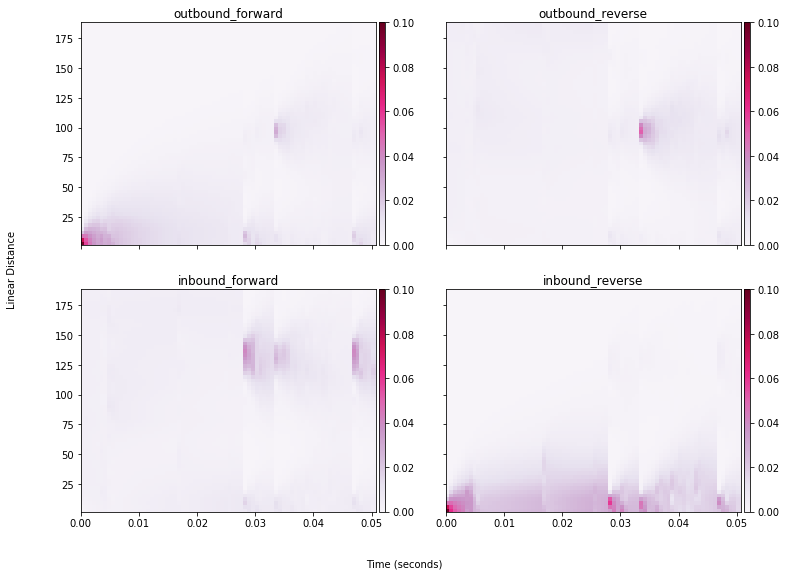

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

def browse_ripple_densities(posterior_density, state_names,
                            place_bin_centers,
                            sampling_frequency=1500):    
    def plot_fits(ripple_ind):
        fig, axes = plt.subplots(2, 2, figsize=(12,9), sharex=True, sharey=True)
        time_length = decision_state_probability[ripple_ind].shape[0]
        time = np.arange(time_length) / sampling_frequency
        n_time = posterior_density[ripple_ind].shape[0]
        n_states = len(state_names)
        new_shape = (n_time, n_states, -1)
        cur_density = np.reshape(posterior_density[ripple_ind], new_shape)
        [time_grid, place_bins] = np.meshgrid(time, place_bin_centers)
        for state_ind, ax in enumerate(axes.flatten()):
            try:
                mesh = ax.pcolormesh(time_grid, place_bins, cur_density[:, state_ind, :].squeeze().T,
                                     cmap='PuRd', vmin=0, vmax=.1)
                ax.set_xlim((time.min(), time.max()))
                ax.set_ylim((place_bin_centers.min(), place_bin_centers.max()))
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="2%", pad=0.05)
                plt.colorbar(mesh, cax=cax)
                ax.set_title(state_names[state_ind])
            except ValueError:
                pass
        fig.text(0.5, 0.04, 'Time (seconds)', ha='center')
        fig.text(0.04, 0.5, 'Linear Distance', va='center', rotation='vertical')
        
    interact(plot_fits, ripple_ind=(0, len(decision_state_probability)-1), continuous_update=False)
        
browse_ripple_densities(posterior_density, state_names,
                        place_bin_centers)

Widget Javascript not detected.  It may not be installed or enabled properly.


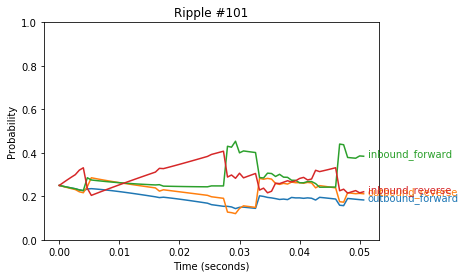

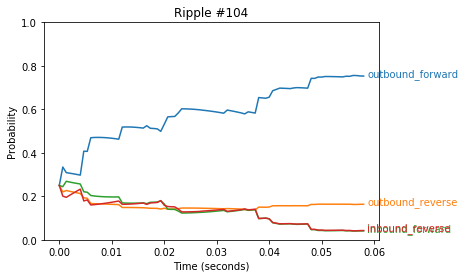

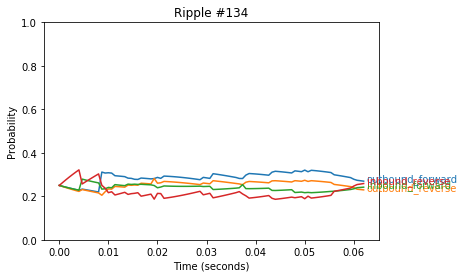

In [24]:
def browse_ripple_fits(decision_state_probability, state_names, sampling_frequency=1500):
    def plot_fits(ripple_ind):
        time_length = decision_state_probability[ripple_ind].shape[0]
        time = np.arange(time_length) / sampling_frequency
        lineObjects = plt.plot(time, decision_state_probability[ripple_ind])
        # plt.legend(lineObjects, discrete_state_names)
        for state_ind, state_name in enumerate(state_names):
                plt.text(time[-1] + (1 / sampling_frequency),
                         decision_state_probability[ripple_ind][-1, state_ind],
                         state_name,
                         color=lineObjects[state_ind].get_color())
        plt.ylim((0, 1))
        plt.xlabel('Time (seconds)')
        plt.ylabel('Probability')
        plt.title('Ripple #{ripple_number}'.format(ripple_number=ripple_ind+1))
    interact(plot_fits, ripple_ind=(0, len(decision_state_probability)-1), continuous_update=False)
        
browse_ripple_fits(decision_state_probability, state_names)

In [25]:
ripple_info

ripple_trajectory ripple_direction  \
animal day epoch ripple_number                                      
HPa    6   2     1                      outbound          reverse   
                 2                      outbound          reverse   
                 3                      outbound          reverse   
                 4                       inbound          reverse   
                 5                      outbound          reverse   
                 6                       inbound          forward   
                 7                      outbound          reverse   
                 8                       inbound          forward   
                 9                      outbound          reverse   
                 10                      inbound          forward   
                 11                      inbound          forward   
                 12                      inbound          reverse   
                 13                     outbound          forward   
                 14                     outbound          forward   
                 15                      inbound          reverse   
                 16                     outbound          reverse   
                 17                     outbound          reverse   
                 18                     outbound          reverse   
                 19                      inbound          reverse   
                 20                     outbound          reverse   
                 21                     outbound          forward   
                 22                     outbound          reverse   
                 23                     outbound          reverse   
                 24                      inbound          reverse   
                 25                      inbound          reverse   
                 26                     outbound          reverse   
                 27                     outbound          reverse   
                 28                     outbound          reverse   
                 29                     outbound          reverse   
                 30                     outbound          reverse   
...                                          ...              ...   
                 172                     inbound          forward   
                 173                     inbound          reverse   
                 174                     inbound          forward   
                 175                     inbound          forward   
                 176                     inbound          reverse   
                 177                     inbound          reverse   
                 178                    outbound          reverse   
                 179                     inbound          forward   
                 180                     inbound          reverse   
                 181                    outbound          forward   
                 182                     inbound          reverse   
                 183                     inbound          reverse   
                 184                     inbound          forward   
                 185                    outbound          reverse   
                 186                     inbound          reverse   
                 187                     inbound          forward   
                 188                    outbound          forward   
                 189                     inbound          reverse   
                 190                     inbound          forward   
                 191                     inbound          reverse   
                 192                     inbound          reverse   
                 193                     inbound          reverse   
                 194                     inbound          reverse   
                 195                    outbound          reverse   
                 196                     inbound          reverse   
                 197         